In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
#
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
#
# from farrow_and_ball import *
from numpy.linalg import eigvals
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from scipy.linalg import expm
from scipy.spatial.distance import squareform

from tqdm import tqdm

In [86]:
def get_graph_laplacian(G, is_signed=True):
    if is_signed:
        A = nx.adjacency_matrix(G).toarray()
        D = np.diag(np.abs(A).sum(axis=1))
        L = D-A
    else:
        L = nx.laplacian_matrix(G).todense()
    return L
def entropy(G, steps, is_signed=False, wTresh=1e-10):
    if is_signed:
        L = get_graph_laplacian(G)
        w = eigvals(L)
    else:
        w = nx.laplacian_spectrum(G)
    wSig = w[w>wTresh]
    t1 = -3#np.log10(1. / np.max(wSig))
    t2 = 1#np.log10(10. / np.min(wSig))
    t = np.logspace(t1,t2, int(steps))
    S = np.zeros(len(t))
    VarL = np.zeros(len(t))
    N = G.number_of_nodes()
    
    for i, tau in enumerate(tqdm(t)):      
        Tr = np.nansum(np.exp(-tau * w))
        T1 = np.divide(np.exp(-w*tau), Tr)
        S[i] = -np.nansum(T1 * np.log(T1)) / np.log(N)
        avgRho = np.nansum(np.multiply(w,np.exp(-tau*w))) / Tr
        av2Rho = np.nansum(np.multiply(np.multiply(w,w),np.exp(-tau*w))) / Tr
        VarL[i] = (av2Rho-avgRho*avgRho)
        
    dS = np.log(N) * np.diff(1-S)/np.diff(np.log(t))
    return 1-S, dS, VarL, t

In [107]:
# stochastic block model parameters
N1 = N2 = 50
sizes = [N1, N2]
probs = [[0.95, 0.01], [0.01, 0.95]]

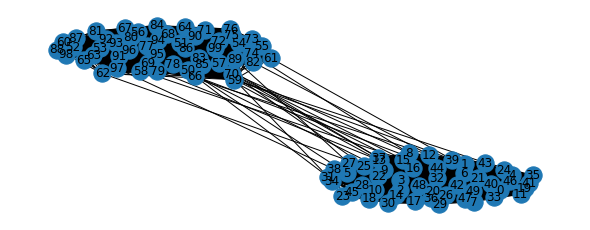

In [108]:
G = nx.stochastic_block_model(sizes, probs, seed=0)
labelList = [i for i in range(G.number_of_nodes())]
plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

In [109]:
# utils
tresh = 0.1
dentroOpts = {'leaf_rotation': 0, 
              'orientation': 'right', 
              'color_threshold': tresh,
              'above_threshold_color': 'k',
              'leaf_font_size': 10,
              'labels': labelList}

In [110]:
# laplacian, spectrum and densities
L = nx.laplacian_matrix(G).todense()
w = 1. / nx.laplacian_spectrum(G)
tau = w[10]
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
dists = squareform(Trho)
linkage_matrix1 = linkage(dists, "average")
tmax = linkage_matrix1[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
print(w)

[-8.74485365e+13  1.14182595e+00  2.47013047e-02  2.37779572e-02
  2.32351141e-02  2.31475002e-02  2.28766852e-02  2.28302778e-02
  2.27147246e-02  2.26985371e-02  2.25469045e-02  2.24642216e-02
  2.22932740e-02  2.22839039e-02  2.22447432e-02  2.21568706e-02
  2.21383595e-02  2.20230858e-02  2.19266105e-02  2.18991233e-02
  2.18820682e-02  2.18422452e-02  2.18025358e-02  2.17895640e-02
  2.16973380e-02  2.16129500e-02  2.15900156e-02  2.15324626e-02
  2.14988669e-02  2.14528932e-02  2.14147464e-02  2.13761449e-02
  2.13150854e-02  2.12739794e-02  2.12319447e-02  2.12147271e-02
  2.11672339e-02  2.11382923e-02  2.11200998e-02  2.10625705e-02
  2.10199420e-02  2.10089816e-02  2.10041348e-02  2.09573328e-02
  2.09150385e-02  2.08766690e-02  2.08457642e-02  2.08128221e-02
  2.07859595e-02  2.06961631e-02  2.06878845e-02  2.06692763e-02
  2.06360709e-02  2.06095632e-02  2.05754211e-02  2.05616233e-02
  2.05294173e-02  2.05085662e-02  2.04982787e-02  2.04804061e-02
  2.04431137e-02  2.04197

NameError: name 'build_colormap' is not defined

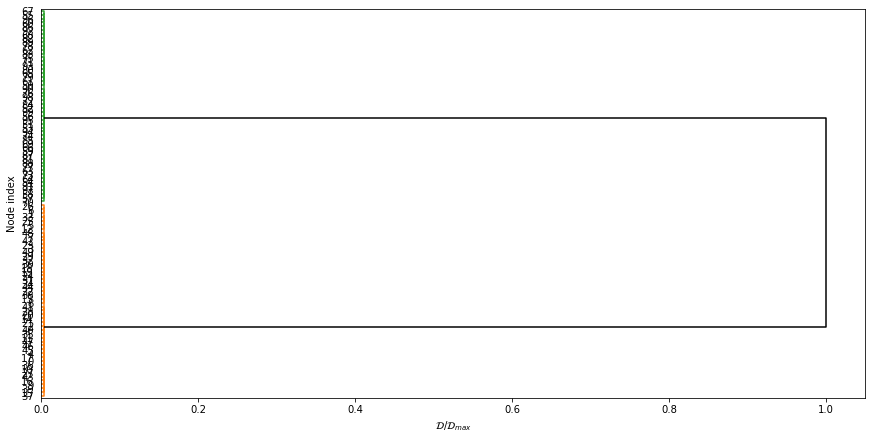

In [111]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['A'].set_ylabel('Node index')

dendrogram(linkage_matrix, ax=ax_dict['A'], **dentroOpts)
CM = fcluster(linkage_matrix, t=tresh, criterion='distance')
cmap = build_colormap(MiscPalette.TONKA, True)
cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
cmap1[0] = [0., 175/255., 187/255., 1.]
cmap1[1] = [252/255., 78/255., 7/255., 1.]

hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])

ax_dict['A'].axvline(x=tresh, c='#ED2939', ls='--')
ax_dict['A'].set_xlim(tmin, tmax)
ax_dict['A'].set_xscale('log')
ax_dict['A'].set_xticks([1e-4, 1e-2, 1e0])
plt.show()

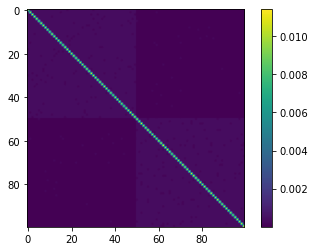

In [112]:
plt.imshow(rho)
plt.colorbar()

100%|██████████| 1000/1000 [00:00<00:00, 21596.08it/s]


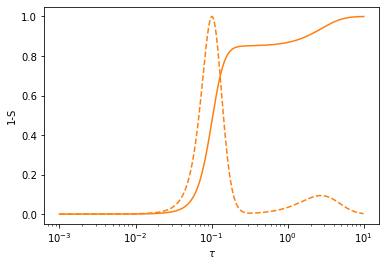

In [113]:
[S1,dS1,VarL1,t1]=entropy(G,1000)

plt.plot(t1,S1,label='ER-05',color='C1')
t11 = (t1[1:]+t1[:-1])/2.0
plt.plot(t11,dS1/np.max(dS1),ls='--',color='C1')


plt.ylabel('1-S')
plt.xlabel(r'$\tau$')

plt.xscale('log')


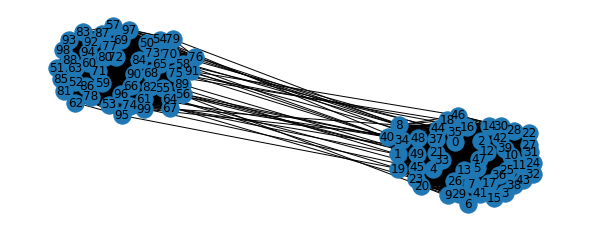

In [114]:
# stochastic block model with subpartition
G = nx.stochastic_block_model(sizes, probs, seed=1)

for edge in G.edges():
    G.add_edge(edge[0], edge[1], weight=1)
    sign = G.get_edge_data(edge[0], edge[1])

plt.figure(figsize=(8,3)) 
nx.draw(G, node_size=300, with_labels = True)

for edge in G.edges(0):
    G[edge[0]][edge[1]]['weight'] =-1

# H = nx.quotient_graph(G, G.graph["partition"], relabel=False)

# community1 = list(list(H.nodes())[0])
# sub_community1 = community1[:len(community1)//2]
# sub_community2 = community1[len(community1)//2:]
# for vertex in sub_community1:
#     for edge in G.edges(vertex):
#         if edge[1] in sub_community2:
#             G[edge[0]][edge[1]]['weight'] =-1

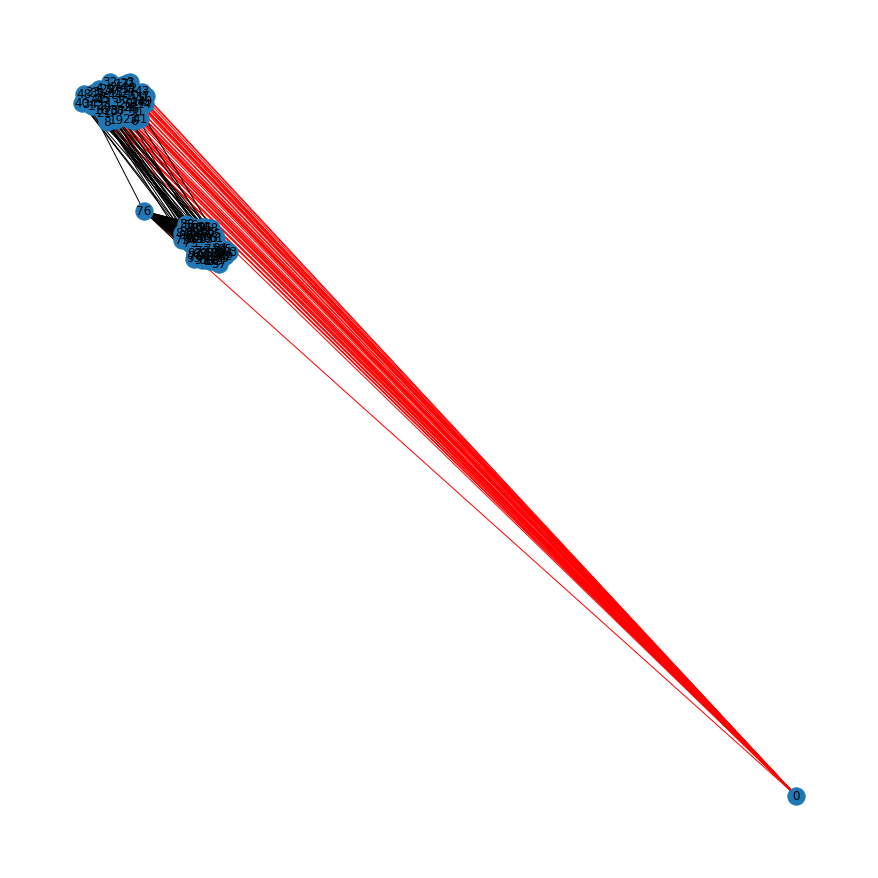

In [179]:
colors = ['r' if G[u][v]['weight'] == -1 else 'k' for u,v in G.edges()]
plt.figure(figsize=(12,12)) 
nx.draw(G, edge_color=colors, node_size=300, with_labels = True)

In [203]:
# laplacian, spectrum and densities
A = nx.adjacency_matrix(G).toarray()
D = np.diag(np.abs(A).sum(axis=1)) 
L = D-A
w = 1. / eigvals(L)
tau = 2e-1
num = expm((-tau*L))
den = np.trace(num)
rho = num/den
Trho = np.copy(1. / rho)
Trho = np.maximum(Trho, Trho.T)#symmetrize
np.fill_diagonal(Trho, 0)
old_d = squareform(Trho)
dists = np.sqrt(1 - old_d/np.max(np.abs(old_d)))
linkage_matrix1 = linkage(dists, "average")
# tmax=linkage_matrix1[::, 2][-1]
# linkage_matrix = linkage(dists/tmax, "average")
#
tmin = linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
# print(w)

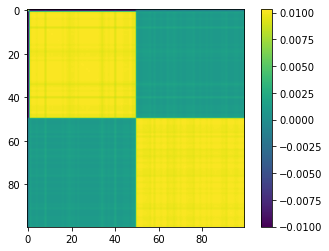

In [204]:
plt.imshow(rho)
plt.colorbar()

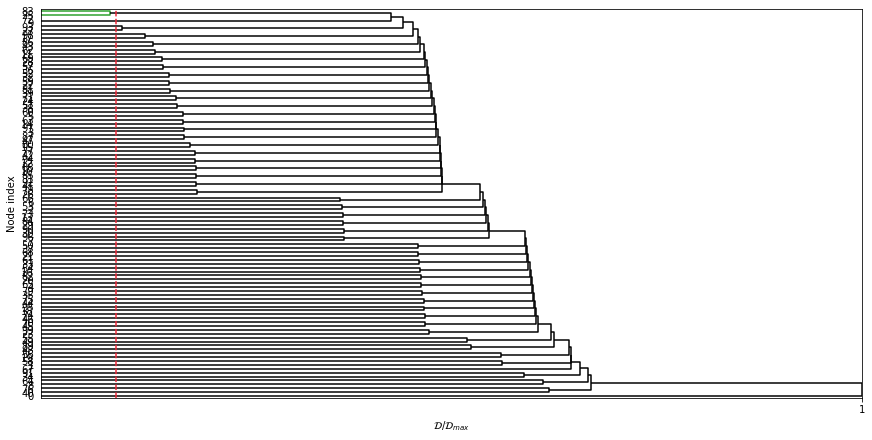

In [205]:
ax_dict = plt.figure(constrained_layout=True,
                     figsize=(12, 6)).subplot_mosaic("A")

dendrogram(linkage_matrix,labels=labelList,ax=ax_dict['A'],leaf_rotation=0,orientation='right',color_threshold=tresh,above_threshold_color='k',leaf_font_size=10)
CM=fcluster(linkage_matrix, t=tresh, criterion='distance')
# cmap = build_colormap(MiscPalette.TONKA, True)
# cmap1 = cmap(np.linspace(0, 1, np.max(CM)))
# cmap1[0]=[0., 175/255., 187/255., 1.]
# cmap1[1]=[252/255., 78/255., 7/255., 1.]
# hierarchy.set_link_color_palette([mplc.rgb2hex(rgb[:3]) for rgb in cmap1])
ax_dict['A'].axvline(x = tresh, color = '#ED2939', linestyle = '--')
tmin=linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax=linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
ax_dict['A'].set_xlim(1e-2,1)
ax_dict['A'].set_xlabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['A'].set_ylabel('Node index')
ax_dict['A'].set_xscale('linear')
ax_dict['A'].set_xticks([1e0])


plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 9397.21it/s]


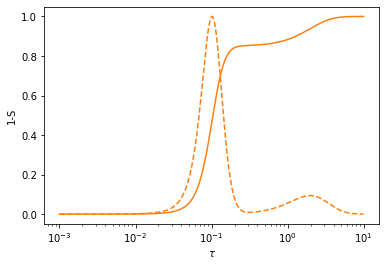

In [145]:
[S1,dS1,VarL1,t1]=entropy(G,1000, is_signed=True)

plt.plot(t1,S1,label='ER-05',color='C1')
t11 = (t1[1:]+t1[:-1])/2.0
plt.plot(t11,dS1/np.max(dS1),ls='--',color='C1')


plt.ylabel('1-S')
plt.xlabel(r'$\tau$')

plt.xscale('log')
